In [1]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from scipy.integrate import dblquad, tplquad, trapezoid
from src.simulations.Simulation import Simulation
import multiprocessing
import datetime


In [2]:
print(const.M_sun)
print(const.G)
print(const.R_jup)

  Name   = Solar mass
  Value  = 1.988409870698051e+30
  Uncertainty  = 4.468805426856864e+25
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018
  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
  Name   = Nominal Jupiter equatorial radius
  Value  = 71492000.0
  Uncertainty  = 0.0
  Unit  = m
  Reference = IAU 2015 Resolution B 3


In [3]:


def sigma_cap(v1Mag, v1primeMag, vBMag, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1primeMag**2 - vBMag**2)**2 - v_esc**4)
    denominator = (v1Mag**2 - v_esc**2)**2 * v1primeMag**4
    return numerator / denominator

# def sigma_cap_dEps(v1, v1_prime, vB, v_esc, muB, kappa):
#     """
#     Differential capture cross-section dσ_cap/dε.

#     Parameters
#     ----------
#     v1 : float
#         Incoming velocity.
#     v1_prime : float
#         Incoming velocity in Body B frame.
#     vB : float
#         Orbital velocity of body B.
#     vesc : float
#         Escape velocity of body A or system.
#     muB : float
#         Reduced mass associated with body B (μ_B).
#     kappa : float
#         Energy dissipation parameter.

#     Returns
#     -------
#     float
#         dσ_cap/dε
#     """
#     sigma_cap_val = 16
#     return sigma_cap_val / kappa

def sigma_collision(R, b, bmin, rmin):
    """
    Collision cross-section σ_collision(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    muB : float
        Reduced mass associated with body B (μ_B).
    r_close : float
        Closest approach distance.

    Returns
    -------
    float
        σ_collision(v1)
    """
    sigma_int_1 = -(0.5*(-b + R + bmin) * (b + R - bmin) * (b - R + bmin) * (b + R + bmin))**0.5
    sigma_int_2 = R**2 * np.arccos((b**2 + R**2 - bmin**2) / (2*b*R))
    sigma_int_3 = rmin**2 * np.arccos((b**2 + bmin**2 - R**2) / (2*b*bmin))

    return sigma_int_1 + sigma_int_2 + sigma_int_3
    

def crossec_circle_R_b(v1Mag,  vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB):
    v1_prime_vec_xy = v1primeVec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)  # shape (n_mu, n_lam)

    # Per-element dot product and cross product
    dot_vB_v1p = np.einsum('i... , i... -> ...', vBVec, v1primeVec)           # shape (n_mu, n_lam)
    cross_v1p_vB = np.cross(v1primeVec, vBVec)                         # shape (3, n_mu, n_lam)

    v1prime_z = v1primeVec[2]                                                  # shape (n_mu, n_lam)
    v1prime_y = v1primeVec[1]                                                  # shape (n_mu, n_lam)
    cross_z = cross_v1p_vB[2]                                                  # shape (n_mu, n_lam)

    # Build g1..g5 as arrays
    g1 = 4*muB * dot_vB_v1p * (v1primeMag**6) * v1prime_z
    g2 = 4*(muB**3) * dot_vB_v1p * (v1primeMag**2) * v1prime_z
    g3 = 4*muB * (v1primeMag**7) * cross_z
    g4 = np.sign(v1prime_y) * (v1_prime_mag_xy**8) * v1_prime_mag_xy * (v1Mag**2 - vesc**2)
    g5 = 2 * np.sign(v1prime_y) * (muB**2) * (v1primeMag**4) * v1_prime_mag_xy * (v1primeMag**2 + vBMag**2 - vesc**2)

    # Avoid divisions by zero and negative expr with masks
    mask = (g1 != 0) & (g4 != 0)
    expr = np.zeros_like(g1)
    expr[mask] = g2[mask]/g1[mask] + (g1[mask]**2 + g3[mask]**2)/(4*g4[mask]**2) - g5[mask]/g4[mask]

    # Only keep positive expr
    pos = mask & (expr > 0)

    Rb = np.zeros_like(expr)
    b  = np.zeros_like(expr)

    Rb[pos] = np.sqrt(expr[pos])
    b[pos]  = -0.5*(g3[pos] + g1[pos]) / g4[pos]

    return Rb, b
    

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def r_min(muA, b, v1_prime):
    """
    Minimum approach distance b_min.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    b : float
        Impact parameter.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        r_min
    """

    e1_prime = np.sqrt(1 + (b**2 * v1_prime**4) / muA**2)
    a1_prime = -b / np.sqrt(e1_prime**2 - 1)
    r_min = (np.sqrt(muA**2 + b**2 * v1_prime**4) - muA) / (v1_prime**2)

    return a1_prime * (1-e1_prime)

def r_AB_vec(rAB, lambda_1):
    """
    Separation vector between bodies A and B r_AB.

    Parameters
    ----------
    rAB : float
        Separation between bodies A and B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    float
        r_AB
    """
    rABVec = np.array([ # broadcast over grid
        np.zeros_like(lambda_1),
        np.ones_like(lambda_1) * rAB,
        np.zeros_like(lambda_1)
    ])
    return rABVec

def b_min(muB, rB, v1_prime):
    """
    Minimum impact parameter b_min.

    Parameters
    ----------
    muB : float
        Reduced mass associated with body B (μ_B).
    rB : float
        Radius of body B.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        b_min
    """
    b_min = np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime

    return b_min

def v_1_mag(v_inf, muA, muB, rAB, rClose):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / rClose)
    return np.sqrt(term1 + term2)

def v_1_vec(v1Mag, lambda_1, beta_1):
    """
    Incoming velocity v1.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1
    """
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1Mag * np.array([
        np.sin(lambda_1) * np.cos(beta_1),
        np.cos(lambda_1) * np.cos(beta_1),
        -np.sin(beta_1),
    ])
    return v1_vec

def v_1_prime_mag(v1primeVec):
    """
    Magnitude of incoming velocity in Body B frame |v1'|.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        |v1'|
    """
    return np.linalg.norm(v1primeVec)

def v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    v1_prime_vec = v1Vec - vBVec
    return v1_prime_vec

def v_2_vec(v1primeVec,v1primeMag,vBVec, muB, b, phi):
    """
    Outgoing velocity v2.
    Parameters
    ----------
    v1primeVec : float
        Incoming velocity vector in Body B frame.
    v1primeMag : float
        Magnitude of incoming velocity in Body B frame.
    muB : float
        Reduced mass associated with body B (μ_B).
    vB : float
        Orbital velocity of body B.
    b : float
        Impact parameter. 
    Returns
    -------
    float
        v2
    """

    v1prime_vec = v1primeVec.copy()
    v1prime_x = v1prime_vec[0]
    v1prime_y = v1prime_vec[1]
    v1prime_z = v1prime_vec[2]
    v1prime_xy = v1prime_vec.copy()
    v1prime_xy[2] = 0.0
    v1primeMag_xy = np.linalg.norm(v1prime_xy)

    q = np.sqrt(1 + v1prime_z**2/v1primeMag_xy**2)

    term1 = vBVec + (b**2 * v1primeMag**4 - muB**2)/(b**2 * v1primeMag**4 + muB**2) * v1primeVec
    term2 = (2 * np.sign(v1prime_y) * muB * v1primeMag * b)/(b**2 * v1primeMag**4 + muB**2) * np.array([
        q * (v1prime_x * v1prime_z * np.sin(phi) - v1primeMag * v1prime_y * np.cos(phi)),
        q * (v1prime_y * v1prime_z * np.sin(phi) + v1primeMag * v1prime_x * np.cos(phi)),
        -v1primeMag_xy**2 * np.sin(phi)
    ])
    return term1 + term2

def v_2_mag(v2Vec):
    """
    Magnitude of outgoing velocity |v2|.
    Parameters
    ----------
    v2Vec : float
        Outgoing velocity vector.
    Returns
    -------
    float
        |v2|
    """
    return np.linalg.norm(v2Vec)

def v_B_vec(vBMag, lambda_1):
    """
    Orbital velocity vector of body B vB.
    Parameters
    ----------
    vBMag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    Returns
    -------
    float
        vB
    """
    vBVec = vBMag * np.array([np.sin(lambda_1), np.cos(lambda_1), np.zeros_like(lambda_1)])
    return vBVec


def chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigma_cap,  rclose, rB, rmin, Rb, b, bmin):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """
    condition0 = Rb > 0.0
    v_max = vesc + 2*vBMag               # scalar
    condition1 = v1Mag < v_max           # scalar, broadcasts
    condition2 = sigma_cap > 0           # array
    condition3 = Rb < rclose             # array
    # If you want to enforce rmin > rB and b > bmin, use these arrays; otherwise skip
    # condition4 = rmin > rB
    condition5 = b > bmin

    # Combine elementwise with &; convert to float (1.0/0.0)
    result_mask = condition0 & condition1 & condition2 & condition3 & condition5
    return result_mask.astype(float)
def chi_inE2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v2Mag, v1Mag, U, E2, rClose):
    """
    Indicator function to check kinematical allowance χ in E2.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ in E2
    """

    # Condition 1
    vesc = v2Mag
    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    condition1 = Rb < rClose

    return 1.0 if condition1 else 0.0

def dsigma_directional_average(sigma_cap, chi):
    """
    Differential directional average cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return (sigma_cap) * chi / (2*np.pi)

def U(muA, muB, rAB, rClose):
    """
    Potential energy U.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    rAB : float
        Separation between bodies A and B.
    rclose : float
        Closest approach distance.

    Returns
    -------
    float
        U parameter
    """
    U  = -(muA / rAB) - (muB / rClose)

    return U

def E2(v2Mag, U):
    """
    Final energy E2.

    Parameters
    ----------
    v2Mag : float
        Magnitude of the outgoing velocity vector.
    U : float
        Potential energy U.

    Returns
    -------
    float
        E2
    """
    return 0.5 * v2Mag**2 + U

def L2(rABVec, v2Vec):
    """
    Angular momentum L2.

    Parameters
    ----------
    rABVec : float
        Separation vector between bodies A and B.
    v2Vec : float
        Outgoing velocity vector.
    muA : float
        Reduced mass associated with body A (μ_A).

    Returns
    -------
    float
        L2
    """
    return np.linalg.norm(np.cross(rABVec, v2Vec))


def a_e(muA, E2, L2):
    """
    Semi-major axis a.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    E2 : float
        Final energy E2.
    L2 : float
        Angular momentum L2.

    Returns
    -------
    float
        a
    """
    a = - muA / (2*E2)
    e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
    return a, e

def b_vector_general(b, v1prime_vec, phi):
    """
    v1prime_vec: 3D numpy array (v1x', v1y', v1z')
    phi: scattering plane angle
    """
    v1prime_vec = np.asarray(v1prime_vec, dtype=float)
    v1_xy_norm = np.linalg.norm(v1prime_vec[:2])
    if v1_xy_norm == 0:
        raise ValueError("v1' has no xy component; b-vector undefined")

    # eq. (6) direction for φ=0, embedded in 3D
    prefac = np.sign(v1prime_vec[1]) / v1_xy_norm
    e_b0 = prefac * np.array([v1prime_vec[1], -v1prime_vec[0], 0.0])

    # unit vector along v1'
    v1prime_norm = np.linalg.norm(v1prime_vec)
    e_v = v1prime_vec / v1prime_norm

    # second perpendicular direction
    e_c = np.cross(e_v, e_b0)
    e_c /= np.linalg.norm(e_c)

    # rotate by φ in the plane perpendicular to v1'
    b_vec = b * (np.cos(phi)*e_b0 + np.sin(phi)*e_c)
    return b_vec


def sigma_cap_in_E2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v1Mag, U, E2):
    """
    Differential directional average cross-section dσ/dΩ in E2.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    v_inf : float
        Velocity at infinity.
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    vB_mag : float
        Orbital velocity magnitude of body B.
    vesc : float
        Escape velocity of body A or system.
    sigcap : float
        Capture cross-section.
    rclose : float
        Closest approach distance.
    r_jupiter : float
        Radius of Jupiter.

    Returns
    -------
    float
        dσ/dΩ in E2
    """
    term1 = (16*np.pi * muB**2 * (U + E2)/(v1primeMag**4 * (v1Mag**2 - 2*(U-E2))**3)) 
    term2 = (vBMag**2 * (2*v1primeMag**2) + np.dot(vBVec, v1primeVec) + (v1primeMag**2 - 2*(U + E2) * np.dot(vBVec, v1primeVec)))
    sigma_cap_E2 = term1 * term2

    return sigma_cap_E2

In [4]:
G = const.G.value
m_Sun = const.M_sun.value
m_Jup =  const.M_jup.value  # Mass of Jupiter
m_Neptune = 5.15*10**-5 * const.M_sun.value  # Mass of Neptune
m_PBH = 1e-13 * const.M_sun.value
r_SJ = (5.2*u.au).to(u.m).value
r_SN = (30.07*u.au).to(u.m).value
v_Jup = 13.06 * 1e3  # km/s to m/s
v_Neptune = 5.45 * 1e3  # km/s to m/s
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
r_neptune = 24622 * 1e3  # in meters
A_jupiter = np.pi * r_jupiter**2

In [ ]:
s = datetime.datetime.now()
name = "Sun_Jupiter"
v_inf_grid = np.linspace(1e3, 1e5/2, 20)  # from 1 km/s to 50 km/s
m_Sun = const.M_sun.value
m_Jup =  const.M_jup.value  # Mass of Jupiter
m_Neptune = 5.15*10**-5 * const.M_sun.value  # Mass of Neptune
m_PBH = 1e-13 * const.M_sun.value
r_SJ = (5.2*u.au).to(u.m).value
r_SN = (30.07*u.au).to(u.m).value
v_Jup = 13.06 * 1e3  # km/s to m/s
v_Neptune = 5.45 * 1e3  # km/s to m/s
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
r_neptune = 24622 * 1e3  # in meters
A_jupiter = np.pi * r_jupiter**2
rAB = r_SJ
rB = r_jupiter
mA = m_Sun
mB = m_Jup
muA = G * mA
muB = G * mB
vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = v_Jup
seed = 42
system_param_dict = {
    'name': name,
    'mA': m_Sun,
    'mB': m_Jup,
    'mC' : m_PBH,
    'rAB': rAB,
    'rB': rB,
    'vB' : vBMag,
    'epsilon': epsilon,
    'seed': seed,
    'rClose': rclose,
}

trials = 100_000_000
sample_size = 200
lambda_limits = [0, 2*np.pi]
cosbeta_limits = [-1, 1]   # cosβ
phi_limits = [0, 2 * np.pi]
rng = np.random.default_rng(seed)
N = trials
# 1) sample direction of incoming PBH (λ, β)
lambda_samples = rng.uniform(lambda_limits[0], lambda_limits[1], size=N)
cosbeta_samples  = rng.uniform(cosbeta_limits[0], cosbeta_limits[1], size=N)    # cosβ

# 2) sample impact parameter b with p(b) ∝ b
b_max = rclose                   # set maximum impact parameter (e.g. rclose)
u_b = rng.uniform(0.0, 1.0, size=N)
b_samples = b_max * np.sqrt(u_b)

# 3) sample scattering-plane angle φ
phi_samples = rng.uniform(phi_limits[0], phi_limits[1], size=N)

def run_simulation(pars):
    system_param_dict = pars[0]
    simulation = Simulation(system_param_dict)
    trials,sample_size, v_inf, lambda_samples, cosbeta_samples, phi_samples, b_samples = pars[1]
    simulation.run_monte_carlo_simulation(trials, sample_size, v_inf, lambda_samples, cosbeta_samples, phi_samples, b_samples)

if __name__ == "__main__":


    # Create a pool of workers
    num_cores = len(v_inf_grid)  # Get the number of available CPU cores
    with multiprocessing.Pool(processes=num_cores) as pool:
        # Distribute the simulations across the cores
        pars = []
        for v_inf in v_inf_grid:
            pars.append((system_param_dict, (trials, sample_size, v_inf, lambda_samples, cosbeta_samples, phi_samples, b_samples)))
        pool.map(run_simulation, pars)
    pool.close()
    pool.join()

    print(f'Execution time: {datetime.datetime.now() - s} for {len(v_inf_grid)} simulations')

/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
/data/a.saricaoglu/repo/captus/src/utils/calculations.py:602: RuntimeWarning: inva

In [ ]:
# Read monte carlo results and plot
import pandas as pd
import glob
import os
save_dir = f'../runs/{name}/Monte_Carlo_Results/'
all_files = glob.glob(os.path.join(save_dir, "monte_carlo_results_*.npz"))
v_dict = {}
for file in all_files:
    data = np.load(file)
    key = int(data['v_inf']/1e3)  # convert to km/s for plotting
    print(f'v_inf = {key} km/s')
    v_dict[key] = data


v_inf = 17 km/s
v_inf = 33 km/s
v_inf = 11 km/s
v_inf = 39 km/s
v_inf = 22 km/s
v_inf = 50 km/s
v_inf = 28 km/s
v_inf = 6 km/s
v_inf = 44 km/s
v_inf = 1 km/s


{17: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v17.3_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 33: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v33.7_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 11: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v11.9_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 39: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v39.1_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 22: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v22.8_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 50: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carlo_results_v50.0_s42.npz' with keys: v_inf, n_captured, sigma_MC_m2, sigma_MC_areaB, a_au..., 28: NpzFile '../runs/Sun_Jupiter/Monte_Carlo_Results/monte_carl

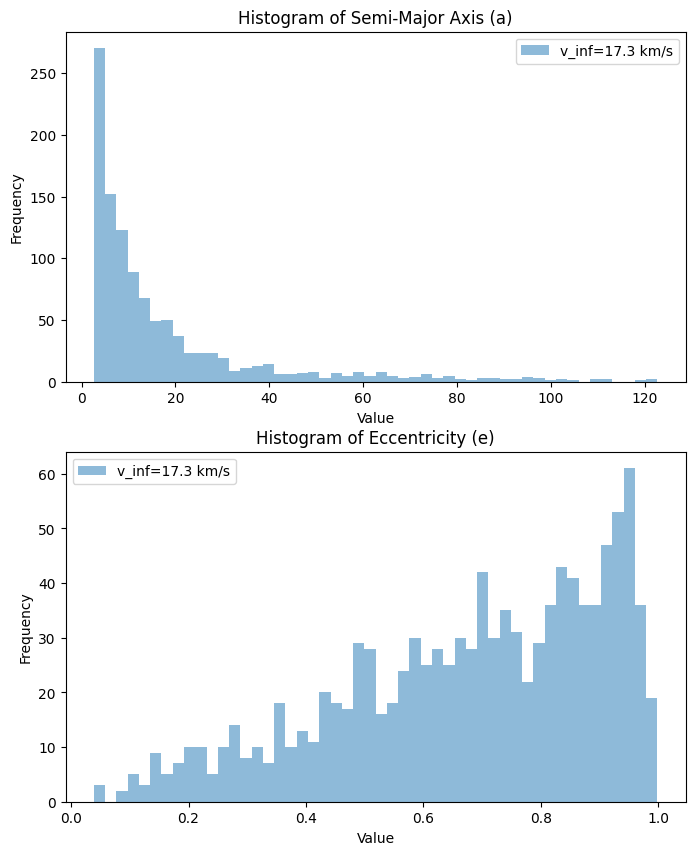

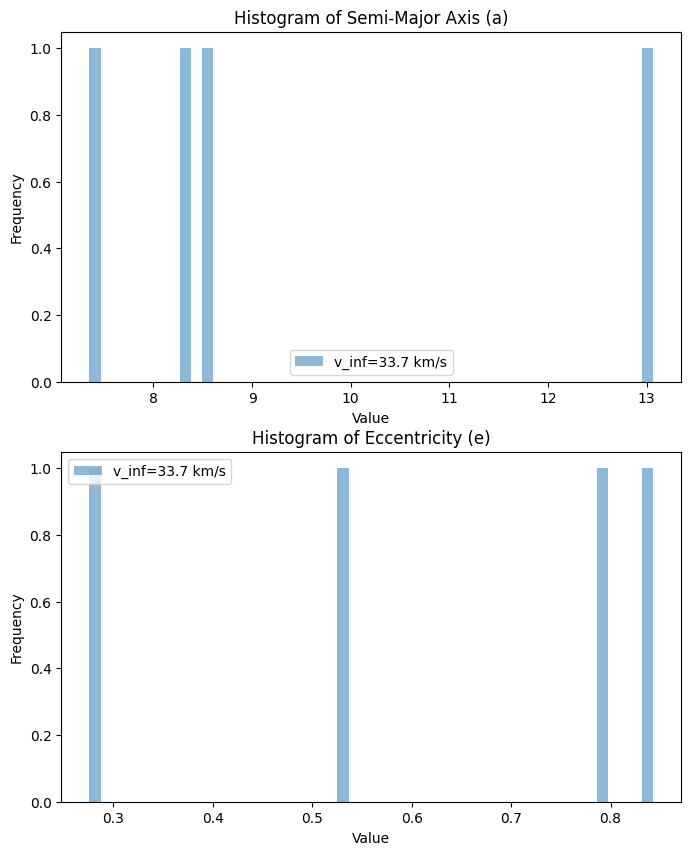

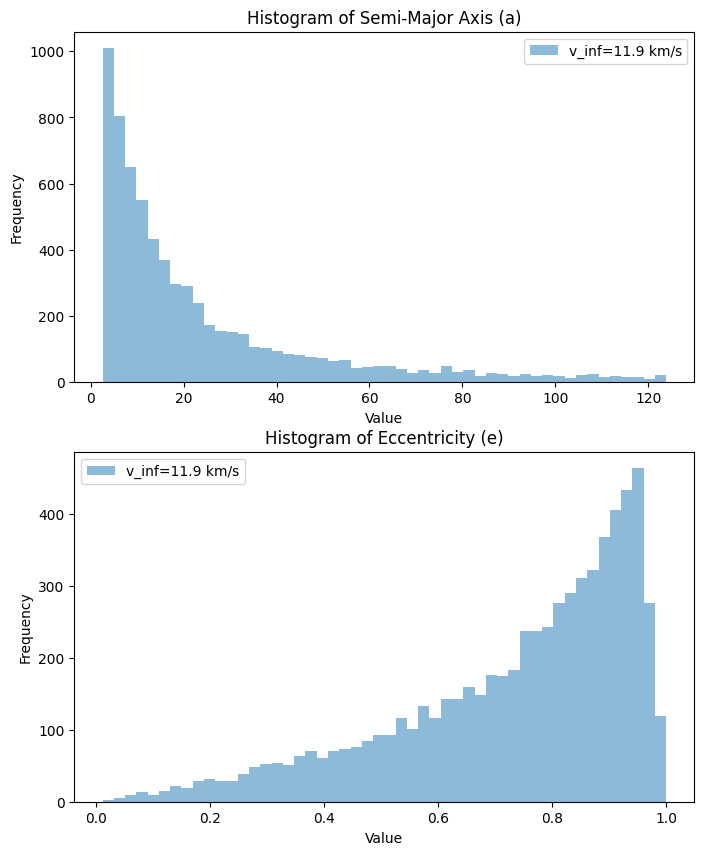

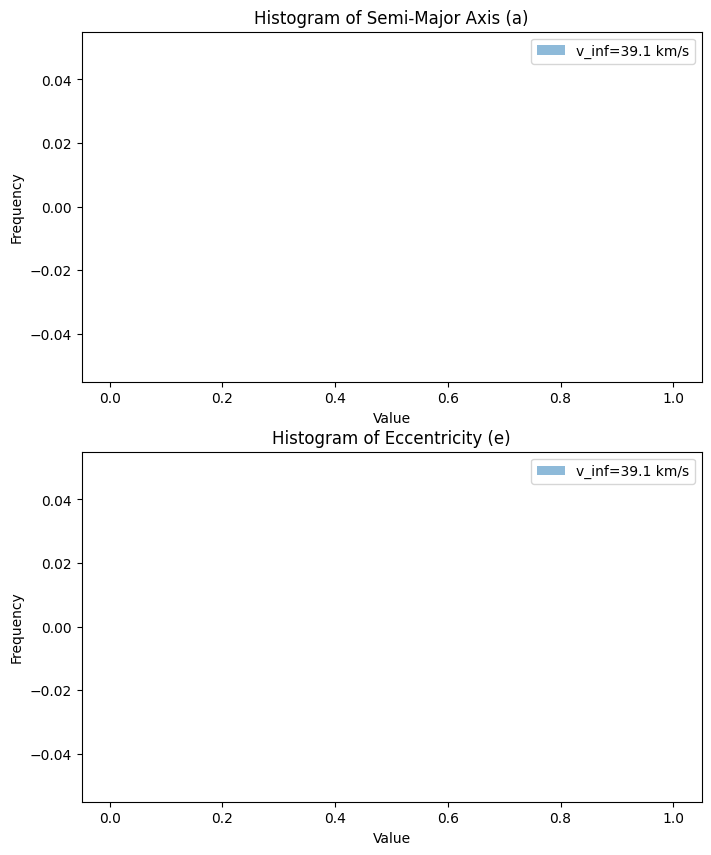

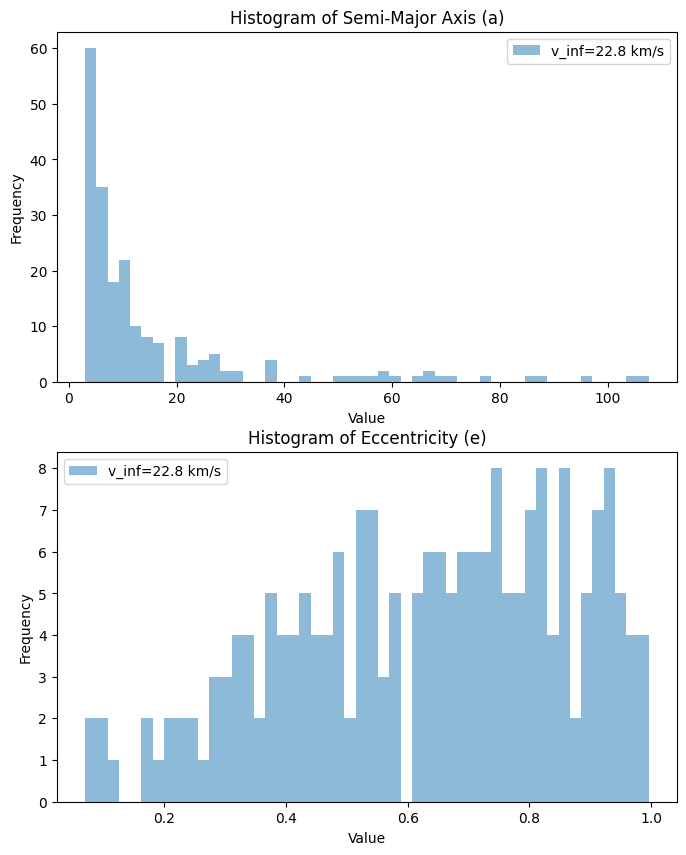

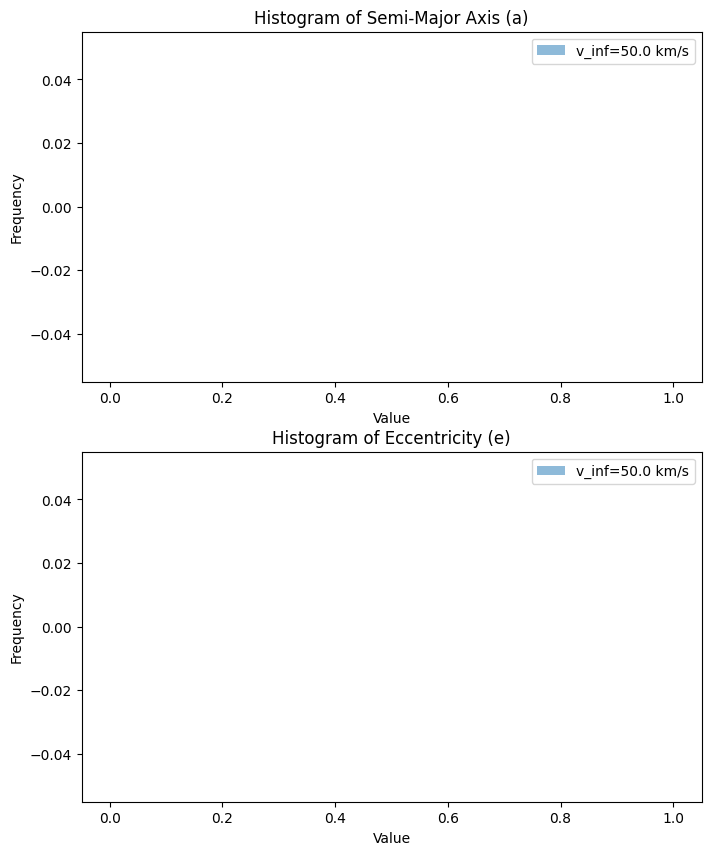

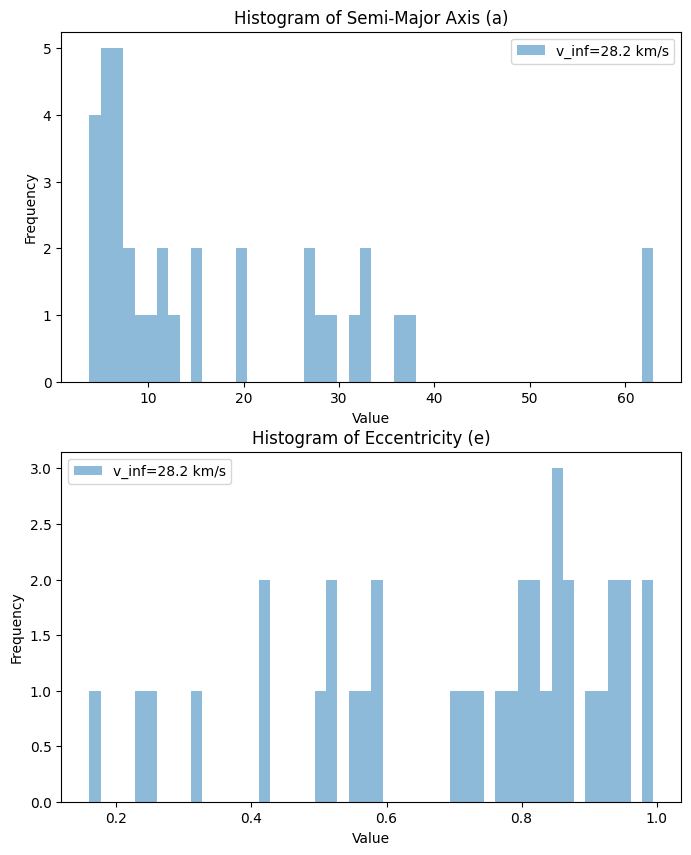

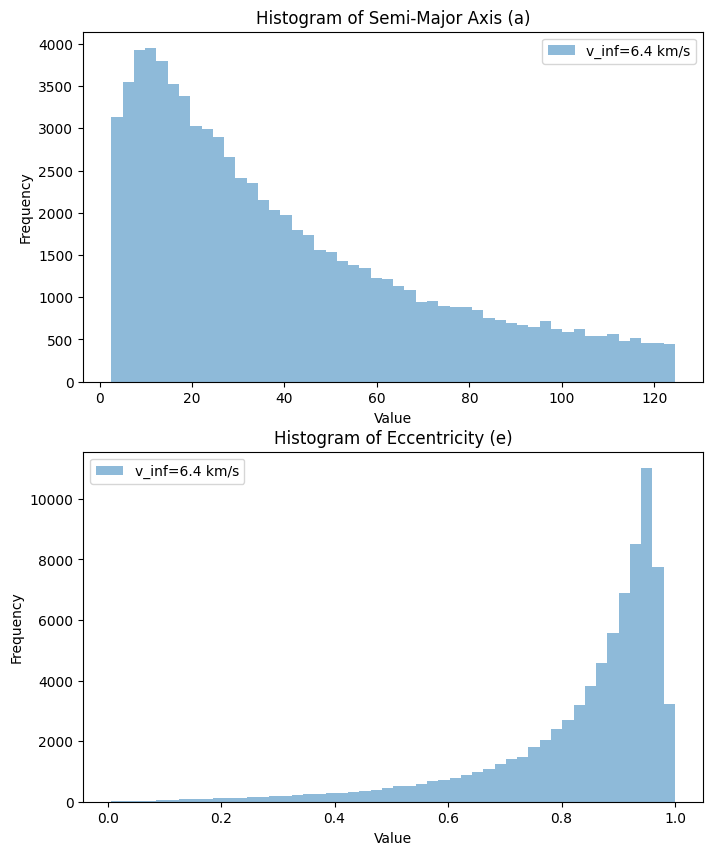

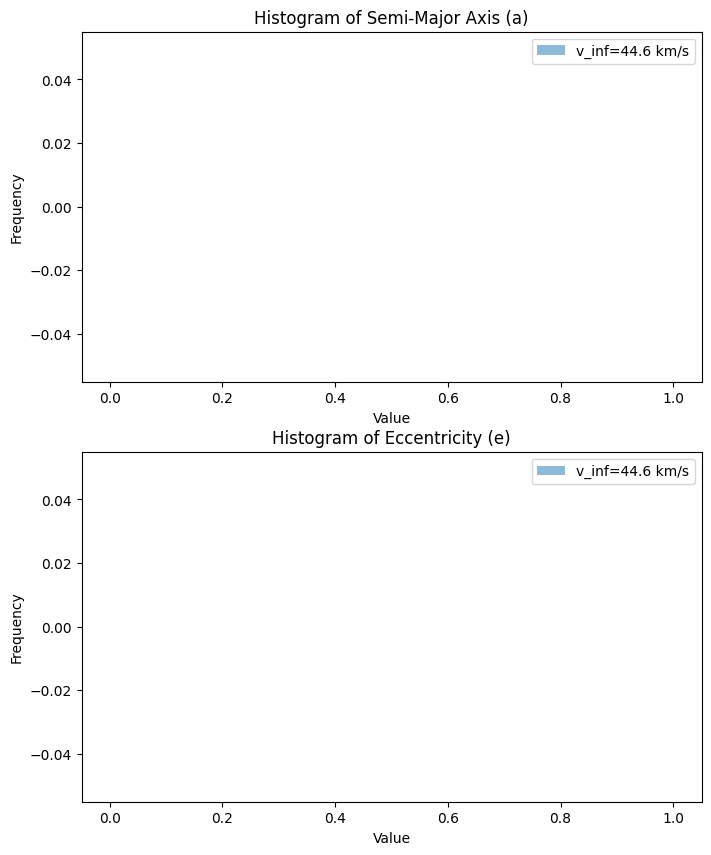

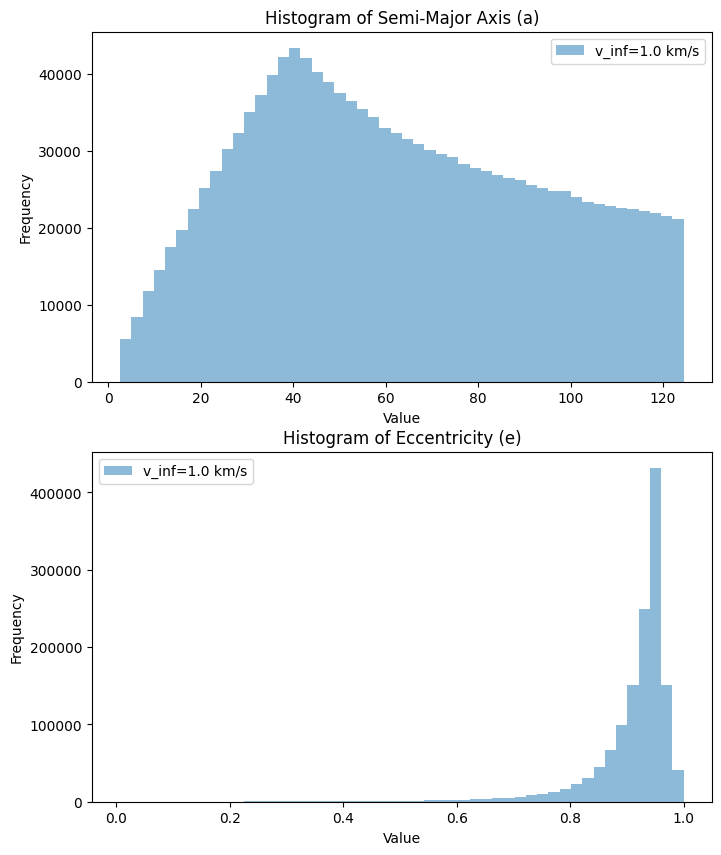

In [ ]:
print(v_dict)  # Print the first DataFrame to verify loading
for v in v_dict.keys():
    data = v_dict[v]
    a_vals = data['a_au']
    e_vals = data['e']
    v_inf = data['v_inf']
    fig, ax = plt.subplots(2, 1, figsize=(8, 10))
    ax[0].hist(a_vals, bins=50, alpha=0.5, label=f'v_inf={v_inf/1e3:.1f} km/s')
    ax[1].hist(e_vals, bins=50, alpha=0.5, label=f'v_inf={v_inf/1e3:.1f} km/s')
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Histogram of Semi-Major Axis (a)')
    ax[1].set_xlabel('Value')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Histogram of Eccentricity (e)')
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [ ]:
for v in v_dict.keys():
    data = v_dict[v]
    a_vals = data['a_au']
    print(f'captured objects for v_inf = {v} km/s: {data['n_captured']}')
    if len(a_vals) < 1000:
        continue
    a_vals_mean = np.mean(a_vals)
    a_vals_std = np.std(a_vals)
    sample_from_a_vals = np.random.choice(a_vals, size=200, replace=False)
    sampled_a_mean = np.mean(sample_from_a_vals)
    sampled_a_std = np.std(sample_from_a_vals)
    # print(f'v_inf = {v} km/s: original population size = {len(a_vals)} a mean = {a_vals_mean:.3f} au, a std = {a_vals_std:.3f} au; sampled a mean = {sampled_a_mean:.3f} au, sampled a std = {sampled_a_std:.3f} au')
    print(f'v_inf = {v} km/s: a_mean - sampled_a_mean = {a_vals_mean - sampled_a_mean:.3f} au, a_std - sampled_a_std = {a_vals_std - sampled_a_std:.3f} au')

captured objects for v_inf = 17 km/s: 1093
v_inf = 17 km/s: a_mean - sampled_a_mean = -1.352 au, a_std - sampled_a_std = -2.452 au
captured objects for v_inf = 33 km/s: 4
captured objects for v_inf = 11 km/s: 6728
v_inf = 11 km/s: a_mean - sampled_a_mean = -2.583 au, a_std - sampled_a_std = -2.300 au
captured objects for v_inf = 39 km/s: 0
captured objects for v_inf = 22 km/s: 207
captured objects for v_inf = 50 km/s: 0
captured objects for v_inf = 28 km/s: 36
captured objects for v_inf = 6 km/s: 78705
v_inf = 6 km/s: a_mean - sampled_a_mean = -0.758 au, a_std - sampled_a_std = -0.387 au
captured objects for v_inf = 44 km/s: 0
captured objects for v_inf = 1 km/s: 1383531
v_inf = 1 km/s: a_mean - sampled_a_mean = -1.699 au, a_std - sampled_a_std = -0.757 au


v_inf = 17 km/s: a_mean - sampled_a_mean = -0.196 au, a_std - sampled_a_std = -0.434 au
v_inf = 11 km/s: a_mean - sampled_a_mean = 1.307 au, a_std - sampled_a_std = 1.738 au
v_inf = 22 km/s: a_mean - sampled_a_mean = -0.935 au, a_std - sampled_a_std = -1.435 au
v_inf = 6 km/s: a_mean - sampled_a_mean = 2.585 au, a_std - sampled_a_std = 1.389 au
v_inf = 1 km/s: a_mean - sampled_a_mean = -1.616 au, a_std - sampled_a_std = 2.398 au

In [ ]:
# --- Monte Carlo ---
N = 100_000 
rng = np.random.default_rng(42)

# 1) sample direction of incoming PBH (λ, β)
lam_samples = rng.uniform(0.0, 2*np.pi, size=N)
mu_samples  = rng.uniform(-1.0, 1.0, size=N)    # cosβ
beta_samples = np.arccos(mu_samples)

# 2) sample impact parameter b with p(b) ∝ b
b_max = rclose                      # set maximum impact parameter (e.g. rclose)
u_b = rng.uniform(0.0, 1.0, size=N)
b_samples = b_max * np.sqrt(u_b)

# fixed Sun–Jupiter separation vector (choose an axis)
rABVec = np.array([0.0,rAB, 0.0])

# 3) sample scattering-plane angle φ
phi_samples = rng.uniform(0.0, 2*np.pi, size=N)

# containers for captures
a_list = []
e_list = []
lambda_list = []    
beta_list = []
b_list = []
phi_list = []

n_captured = 0

# specific potential around Sun at rAB
U_val = -muA / rAB - muB/rclose

for lam, beta, b, phi in zip(lam_samples, beta_samples, b_samples, phi_samples):
    # incoming and planet velocity
    v1Vec = v_1_vec(v1Mag, lam, beta)  # (3,)
    vBVec = v_B_vec(vBMag, lam)        # (3,)

    # relative velocity in Jupiter frame
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lam, beta)
    v1primeMag = np.linalg.norm(v1primeVec)

    if v1primeMag == 0:
        continue

    # optional: skip collisions with Jupiter
    if b < r_jupiter:
        continue

    # outgoing velocity in Sun frame
    v2Vec = v_2_vec(v1primeVec, v1primeMag, vBVec, muB, b, phi)
    v2Mag = v_2_mag(v2Vec)

    # specific energy around the Sun
    E2_val = 0.5*v2Mag**2 + U_val

    if E2_val + muB/rclose  < 0:
        # bound to Sun
        L2_val = L2(rABVec, v2Vec)
        a_val, e_val = a_e(muA, E2_val, L2_val)

        # physical sanity checks: a>0, 0<=e<1
        if a_val > 0 and 0 <= e_val < 1:
            a_list.append(a_val)
            e_list.append(e_val)
            lambda_list.append(lam)    
            beta_list.append(beta)
            b_list.append(b)
            phi_list.append(phi)
            n_captured += 1

# convert to arrays
a_arr = np.array(a_list)   # meters
e_arr = np.array(e_list)

# estimate capture cross-section:
sigma_MC = (n_captured / N) * np.pi * b_max**2

print("MC capture cross-section:", sigma_MC, "m^2")
print("In units of Jupiter area:", sigma_MC / A_jupiter)

# orbital element stats
a_au = (a_arr*u.m).to(u.au).value
print("Number of captured orbits:", len(a_au))
print("a (au): mean =", np.mean(a_au), "std =", np.std(a_au))
print("e: mean =", np.mean(e_arr), "std =", np.std(e_arr))


MC capture cross-section: 1.5883513624828928e+17 m^2
In units of Jupiter area: 9.891947752227246
Number of captured orbits: 4
a (au): mean = 26.625715408660696 std = 29.21729655450784
e: mean = 0.8876891821408183 std = 0.08264972664869287


min a: 2.878823647252925 au, max a: 76.46780286174986 au
Number of captured orbits with a < 120 au: 4
mean of a < 120 au: 26.625715408660696 au


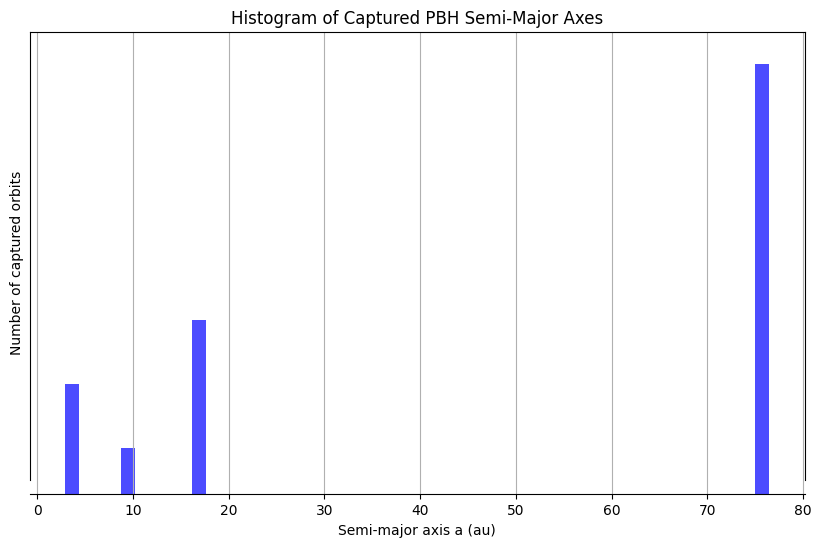

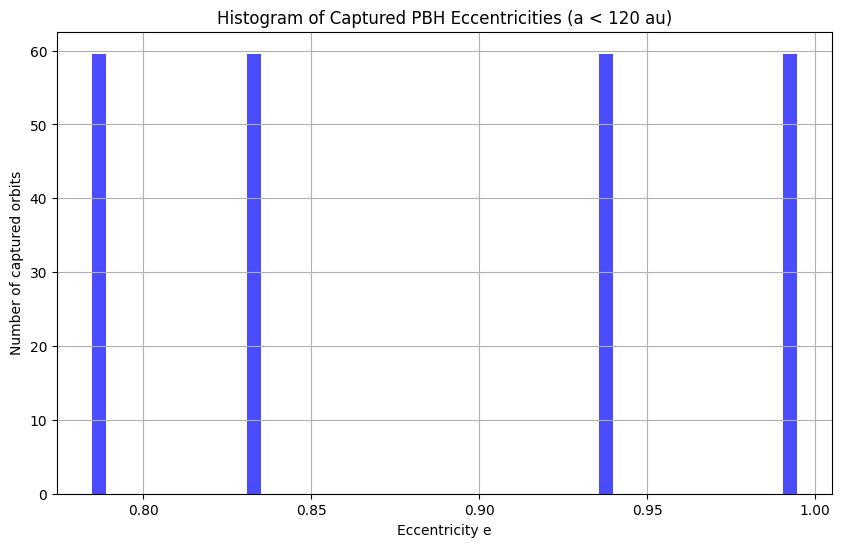

In [ ]:
print(f'min a: {np.min(a_au)} au, max a: {np.max(a_au)} au')
a_less_120au = a_au[a_au < 120.0]
print("Number of captured orbits with a < 120 au:", len(a_less_120au))
print(f'mean of a < 120 au: {np.mean(a_less_120au)} au')
# Plot histogram of semi-major axes
plt.figure(figsize=(10, 6))
plt.hist(a_less_120au, density=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Semi-major axis a (au)')
plt.yscale('log')
plt.ylabel('Number of captured orbits')
plt.title('Histogram of Captured PBH Semi-Major Axes')
plt.grid()
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(e_arr[a_au < 120.0], density=True, bins=50, color='blue', alpha=0.7)
plt.xlabel('Eccentricity e')
plt.ylabel('Number of captured orbits')
plt.title('Histogram of Captured PBH Eccentricities (a < 120 au)')
plt.grid()
plt.show()

with U only including the sun term
min a: 2.7878306869697593 au, max a: 4614.337591052041 au
Number of captured orbits with a < 120 au: 442
mean of a < 120 au: 16.331048113325295 au

In [ ]:
# Sun-Jupiter- system, fixed mC = 1e-7
# lambda1 in interval [0, 2pi] beta in interval [-pi/2, pi/2] uniform random sampling
# Multiprocessing
import rebound
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import datetime
from astropy.table import Table
import logging
import sys
import pandas as pd
from astropy import constants as const
from astropy import units as u  
import multiprocessing
import shutil
from mpl_toolkits.mplot3d import Axes3D


s = datetime.datetime.now()
# Displays Time
current_time = s.strftime('%H%M')
print("current time :", current_time)
if not os.path.exists(f'/data/a.saricaoglu/repo/COMPAS/Files/Capture/{str(s.strftime("%m.%d"))}/{current_time}/LBImpB_Variation/'): 
    os.makedirs(f'/data/a.saricaoglu/repo/COMPAS/Files/Capture/{str(s.strftime("%m.%d"))}/{current_time}/LBImpB_Variation/') 
directoryf = f'/data/a.saricaoglu/repo/COMPAS/Files/Capture/{str(s.strftime("%m.%d"))}/{current_time}/LBImpB_Variation/' 
# if not os.path.exists(f'{directoryf}/discarded/'):
#     os.makedirs(f'{directoryf}/discarded/')
# directoryf_discarded = f'{directoryf}/discarded/'
if not os.path.exists(f'/data/a.saricaoglu/repo/COMPAS/Plots/Capture/{str(s.strftime("%m.%d"))}/{current_time}/'): 
    os.makedirs(f'/data/a.saricaoglu/repo/COMPAS/Plots/Capture/{str(s.strftime("%m.%d"))}/{current_time}/') 
directoryp = f'/data/a.saricaoglu/repo/COMPAS/Plots/Capture/{str(s.strftime("%m.%d"))}/{current_time}/' 



# Redirect stdout and stderr to the log file
# class StreamToLogger:
#     def __init__(self, logger, log_level):
#         self.logger = logger
#         self.log_level = log_level
#         self.linebuf = ''

#     def write(self, buf):
#         for line in buf.rstrip().splitlines():
#             self.logger.log(self.log_level, line.rstrip())

#     def flush(self):
#         pass

class EnergyError(Exception): pass
class EscapeError(Exception): pass
class CollisionError(Exception): pass
class RangeError(Exception): pass
class MaxYearForBError(Exception): pass
class InvalidPeriodError(Exception): pass
class PlottingError(Exception): pass

# sys.stdout = StreamToLogger(logging.getLogger('STDOUT'), logging.INFO)
# sys.stderr = StreamToLogger(logging.getLogger('STDERR'), logging.ERROR)

import time

def run_simulation(pars):

    def save_result(result):
        result_keys = ['i', 'start_info', 'errors', 'start_distances', 'lifetime', 'final_energy_c', 'termination_flag', 'eccentricities', 'semi_major_axes', 'times']
        result_dict = {key: value for key, value in zip(result_keys, result)}
        out_npz = os.path.join(directoryf, f"sim_{i}.npz")
        os.makedirs(os.path.dirname(out_npz), exist_ok=True)
        np.savez(out_npz, **result_dict)
    
    def track_preprocess_errors(errors):
        error_list = ['v1primeMag is zero', 'invalid impact parameter b']
        l = []
        for e, e_l in zip(errors, error_list):
            if e:
                l.append(e_l)
        return l
    



    i, beta, lambda1, phi, b, a_c, e_c = pars

    # Convert impact parameter from meters to AU (MC upstream is in SI)
    b = (b*u.m).to(u.au).value

    rng = np.random.default_rng(42 + i)  # Different seed for each process
    # script_name = 'capture_calculations_copy3'
    # log_filename = f"{directoryf}{script_name}/{i}.log"
    # os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    print(f"Simulation {i} of {len(a_list)} starting at {datetime.datetime.now()}")

    epsilon = 0.1
    eB = 0.0489  # Jupiter eccentricity
    eC = e_c  # from MC
    # Use rebound units: ('AU', 'yr', 'Msun')
    # Set masses in Msun
    mA = 1.0  # Msun
    mB = const.M_jup.to(u.Msun).value  # Jupiter mass in Msun
    mC = m_PBH  # Msun

    # Radii in AU
    rA = const.R_sun.to(u.au).value
    rB = const.R_jup.to(u.au).value
    rC = 1.9747e-21  # PBH radius in AU for 1e-13 Msun

    # Semi-major axis in AU
    aB = (r_SJ*u.m).to(u.au).value
    aC = a_c  # from MC in AU

    iB = 1.304 * (np.pi/180)  # Jupiter inclination in radians
    iC = rng.uniform(0, np.pi)  # PBH inclination in radians

    thetaB = 0.0  # longitude of ascending node for Jupiter
    thetaC = rng.uniform(0, 2*np.pi)  # PBH longitude of ascending node

    # Velocity at infinity in AU/yr
    v_inf = (20*u.km/u.s).to(u.au/u.yr).value

    # Gravitational parameter in these units: G = 4*pi^2 AU^3/(Msun*yr^2)

    # print(f"mA: {mA}, mB: {mB}, mC: {mC}, rA: {rA}, rB: {rB}, aB: {aB}, aC: {aC}, v_inf: {v_inf}")

    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.integrator = "MERCURIUS"
    sim.add(m=mA, r=rA)  # Sun
    sim.add(m=mB, a=aB, e=eB, r=rB, inc=iB, theta=thetaB, primary=sim.particles[0])  # Jupiter
    sim.add(m=mC, a=aC, e=eC, r=rC, inc=iC, theta=thetaC, primary=sim.particles[0])  # placeholder for C
    opB = sim.particles[1].P
    G_unit = sim.G  # 4*pi^2 in these units
    sim.move_to_com()




    # Helper functions in AU, yr, Msun
    def v_esc_AU(muA, rAB):
        return np.sqrt(2*muA/rAB)

    def r_close_AU(epsilon, mA, mB, rAB):
        # dimensionless factor * AU
        return rAB * (epsilon * mB / mA)**(1/3)

    def v_1_mag_AU(v_inf, muA, muB, rAB, rClose):
        term1 = v_inf**2 + (2*muA/rAB)
        term2 = (2*muB/rClose)
        return np.sqrt(term1 + term2)

    def b_min_AU(muB, rB, v1_prime):
        # muB in AU^3/yr^2, rB in AU, v1_prime in AU/yr -> b in AU
        return np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime


    # # Compute params in AU/yr/Msun
    muA = G_unit * mA
    muB = G_unit * mB
    rclose = r_close_AU(epsilon, mA, mB, aB)
    v1Mag = v_1_mag_AU(v_inf, muA, muB, aB, rclose)

    # Build incoming velocity vector in AU/yr
    v1Vec = v_1_vec(v1Mag, lambda1, beta)  # returns 3-vector consistent with our convention
    v1_normalised = v1Vec / np.linalg.norm(v1Vec)

    vBVec = np.array(sim.particles[1].vxyz)  # AU/yr
    vBMag = np.linalg.norm(vBVec)

    v1prime = v_1_prime_vec(v1Vec, vBVec, lambda1, beta)
    v1primeMag = np.linalg.norm(v1prime)

    if v1primeMag == 0:
        vprimemag_error = True
    else:
        vprimemag_error = False

    # # Impact parameter limits in AU
    bmax = rclose
    bmin = b_min_AU(muB, rB, v1primeMag)

    if (b < bmin) or (b > bmax) or (bmax < bmin):
        b_error = True
    else:
        b_error = False

    error_list = track_preprocess_errors([vprimemag_error, b_error])
    # # Position at closest approach (AU)
    # r_c = -v1_normalised * rclose

    # # Orthogonal offset vector for given φ (AU)
    # result_vector = b_vector_general(b, v1prime, phi)

    # offset_x = result_vector[0] + r_c[0]
    # offset_y = result_vector[1] + r_c[1]
    # offset_z = result_vector[2] + r_c[2]

    # Add PBH C with initial velocity equal to v1Vec (AU/yr)
    # sim.add(m=mC,
    #         x=sim.particles[1].x + offset_x,
    #         y=sim.particles[1].y + offset_y,
    #         z=sim.particles[1].z + offset_z,
    #         vx=v1Vec[0], vy=v1Vec[1], vz=v1Vec[2])

    # print(f'bmin {bmin}, bmax {bmax}')
    initial_BC_distance = sim.particles[1] ** sim.particles[2]
    initial_AB_distance = sim.particles[0] ** sim.particles[1]
    initial_AC_distance = sim.particles[0] ** sim.particles[2]
    start_separation = f'Initial distances: BC {initial_BC_distance}, AB {initial_AB_distance}, AC {initial_AC_distance}'



    P_C = sim.particles[2].P
    P_B = sim.particles[1].P

    sim.dt = P_C * 0.05

    snap_rate = 20
    snap_interval = sim.dt * snap_rate
    t_end = int(1e6) * P_C
    t_min = int(1e3) * P_C
    t_max = int(1e7) * P_B
    # aC_max = aB * 40

    eccentricities = []
    semi_major_axes = []
    times = []
    E_c_cond, flag = None, None
    max_steps = int(np.ceil(t_end / sim.dt))
    sim.collision = "direct"

    start_info = (f'dt: {sim.dt}, snapshot_rate: {snap_rate}, snap_interval: {snap_interval}, max steps: {max_steps}, '
          f't_end: {t_end}, t_min: {t_min}, t_max: {t_max}, orbital period C: {P_C}, orbital period B: {P_B}, '
          f'rclose {rclose}, vC wrt vB: {np.linalg.norm(vBVec - np.array(sim.particles[2].vxyz))}, '
          f'b: {b} bmin: {bmin}, bmax: {bmax}')

    if not np.isfinite(P_C) or P_C <= 0:
        error_list.append('invalid orbital period C')
        save_result([i, start_info, error_list, start_separation, sim.t, None, None, None, None, None])
        raise InvalidPeriodError(f"Invalid orbital period for C: {P_C}")
    if not np.isfinite(P_B) or P_B <= 0:
        error_list.append('invalid orbital period B')
        save_result([i, start_info, error_list, start_separation, sim.t, None, None, None, None, None])
        raise InvalidPeriodError(f"Invalid orbital period for B: {P_B}")

    if not np.isfinite(sim.dt) or sim.dt <= 0:
        error_list.append('invalid time step')
        save_result([i, start_info, error_list, start_separation, sim.t, None, None, None, None, None])
        raise InvalidPeriodError(f"Invalid time step: {sim.dt}")
    counter = 0
    # plot_counter = 0
    flag = None
    E_initial = sim.energy()
    
    yr = 0
    try:
        ops = rebound.OrbitPlotSet(sim, slices=True, unitlabel="[AU]", color=["black", "red"])
        ops.fig.savefig(f'{directoryp}Initial_Orbits_Simulation_{i}.png')


        for j in range(1, max_steps):
            time = j * sim.dt
            sim.integrate(time, exact_finish_time=0)
            E_current = sim.energy()
            error = abs(E_current - E_initial)/E_initial
            if counter == snap_rate:
                # Store positions and orbital elements
                # positions_jup[j] = [sim.particles[1].x, sim.particles[1].y, sim.particles[1].z]
                # positions_pbh[j] = [sim.particles[2].x, sim.particles[2].y, sim.particles[2].z]

                orbit = sim.particles[2].orbit(primary=sim.particles[0])
                eccentricities.append(orbit.e)
                semi_major_axes.append(orbit.a)
                times.append(sim.t)
                counter = 0
                # if plot_counter > snap_plot_rate:
                #     ops.update()
                #     ops.fig.savefig(f'{directoryp}Orbits_Simulation_{i}_Time_{int(sim.t)}.png')
                #     plot_counter = 0

            # Specific orbital energy of C around A (AU^2/yr^2)
            Evc = 0.5 * (sim.particles[2].vx**2 + sim.particles[2].vy**2 + sim.particles[2].vz**2)
            rAC = np.abs(sim.particles[2] ** sim.particles[0])
            E_c_cond = Evc - (G_unit*sim.particles[0].m / rAC)

            # Specific orbital energy of B around A (AU^2/yr^2)
            Evb = 0.5 * (sim.particles[1].vx**2 + sim.particles[1].vy**2 + sim.particles[1].vz**2)
            rAB = np.abs(sim.particles[1] ** sim.particles[0])
            E_b_cond = Evb - (G_unit*sim.particles[0].m / rAB)

            # if firstCaptureA != True:
            #     capture = capture + 1 if E_cond < 0 else 0
            #     if capture > 3:
            #         firstCaptureA = True

            # for p in sim.particles:
            #     if p.last_collision == sim.t:
            #         flag = 'collision'
            #         raise CollisionError(f"Collision detected at time {sim.t}")
                
            if error > 1e-5:
                flag = 'energy_conservation'
                raise EnergyError(f"Error in energy conservation: {error}")

            if (E_c_cond > 0):
                flag = 'escape_C'
                raise EscapeError(f"Particle C is free: E_c:  {E_c_cond}, rCB: {np.abs(sim.particles[2] ** sim.particles[0])}")
            if E_b_cond > 0:
                flag = 'escape_B'
                raise EscapeError(f"Particle B is free: E_b: {E_b_cond}, rAB: {np.abs(sim.particles[1] ** sim.particles[0])}")

            if sim.t > t_max:
                flag = 'time_exceeded'
                raise MaxYearForBError(f"Maximum time for B exceeded: {sim.t} > {t_max}")



            # yr += step
            counter += 1
            # plot_counter += 1
            # if yr == int(t_min):
            #     print(f"Simulation {i} at time {sim.t}, step {j}")
            #     print(f'Eccentricity of C : {sim.particles[2].e}')
            #     print(f'PBH E_cond: {E_c_cond}, Jupiter E_cond {E_b_cond} rCB {sim.particles[1]  ** sim.particles[2]}, rAC: {rAC}, error {error}')
            #     yr = 0
    except (PlottingError, rebound.Collision, EnergyError, EscapeError, MaxYearForBError) as e:
        print(f"Error during integration: {e}, Simulation failed for system {i}, at time {sim.t}. Script continues...")

    # E_final = sim.energy()
    # energy_change = abs(E_final - E_initial)/E_initial
    # print(f'final energy {E_final}, final time {sim.t}, final distance {sim.particles[1]  ** sim.particles[2]}, energy change {energy_change}')

    # print(f'r_close = {rclose} and initial BC separation =  {initial_BC_distance}')
    ops.update()
    ops.fig.savefig(f'{directoryp}Final_Orbits_Simulation_{i}_Time_{int(sim.t)}_Flag_{flag}.png')
    ops.fig.clf()

    # result = {
    #     "i": i,
    #     "start_info": start_info,
    #     "errors": error_list,
    #     "start_distances": start_separation,
    #     "lifetime": sim.t,
    #     "final_energy_c": E_c_cond,
    #     "termination_flag": flag,
    #     "eccentricities": np.array(eccentricities, dtype=float),
    #     "semi_major_axes": np.array(semi_major_axes, dtype=float),
    #     'times': np.array(times, dtype=float),
    # }

    save_result([i, start_info, error_list, start_separation, sim.t, E_c_cond, flag,
                 np.array(eccentricities, dtype=float), np.array(semi_major_axes, dtype=float),
                 np.array(times, dtype=float)])

    print(f"Simulation {i} of {len(a_list)} completed at {datetime.datetime.now()}")
    

# Number of simulations

if __name__ == "__main__":


    # Create a pool of workers
    num_cores = 30  # Get the number of available CPU cores
    with multiprocessing.Pool(processes=num_cores) as pool:
        # Distribute the simulations across the cores
        pars = []
        i = 0
        for lambda1, beta, phi, b, a_c, e_c in zip(lambda_list, beta_list, phi_list, b_list, a_au, e_list):
            i += 1
            pars.append((i, beta, lambda1, phi, b, a_c, e_c))
        pool.map(run_simulation, pars)
    pool.close()
    pool.join()

    print(f'Execution time: {datetime.datetime.now() - s} for {i} simulations')


current time : 1225
Simulation 4 of 4 starting at 2025-12-14 12:25:24.938444Simulation 1 of 4 starting at 2025-12-14 12:25:24.938319Simulation 3 of 4 starting at 2025-12-14 12:25:24.938349Simulation 2 of 4 starting at 2025-12-14 12:25:24.938320





Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Error during integration: Particle B is free: E_b: 3.510595835979777e+16, rAB: 5.016939155898327, Simulation failed for system 3, at time 7.988277628841612e-09. Script continues...Error during integration: Particle B is free: E_b: 1.4105888106342006e+18, rAB: 4.95473467616377, Simulation failed for system 2, at time 3.5348548319421616e-09. Script continues...

Error during integration: Two particles collided (d < r1+r2), Simulation failed for system 1, at time 7.182725014276521e-08. Script continues...


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Error during integration: Particle B is free: E_b: 4.707842244886031e+20, rAB: 4.942461940458849, Simulation failed for system 4, at time 4.748941439451701e-13. Script continues...


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Simulation 3 of 4 completed at 2025-12-14 12:25:25.138375
Simulation 2 of 4 completed at 2025-12-14 12:25:25.146450
Simulation 4 of 4 completed at 2025-12-14 12:25:25.163871
Simulation 1 of 4 completed at 2025-12-14 12:25:25.167042
Execution time: 0:00:00.390475 for 4 simulations


In [ ]:
# read from saved npz files and aggregate results
all_lifetimes = []
all_eccentricities = []
all_semi_major_axes = []
alltimes = []
ids = []
for filename in os.listdir('/data/a.saricaoglu/repo/COMPAS/capture/runs/Sun_Jupyter_System'):
    if filename.endswith(".npz"):
        data = np.load(os.path.join('/data/a.saricaoglu/repo/COMPAS/capture/runs/Sun_Jupyter_System', filename), allow_pickle=True)
        sys_id = data['i']
        ids.append(sys_id)
        all_lifetimes.append((sys_id, data['lifetime'], data['final_energy_c'], data['termination_flag']))
        all_eccentricities.append((sys_id, data['eccentricities']))
        all_semi_major_axes.append((sys_id, data['semi_major_axes']))   
        alltimes.append((sys_id, data['times'])) 
        start_info = data['start_info']
        start_distances = data['start_distances']
        errors = data['errors']
        print(f"Loaded data from {filename}: {start_info}, {start_distances}, {errors}")
print("Aggregated Lifetimes:", all_lifetimes)
print("Aggregated Eccentricities:", all_eccentricities)
print("Aggregated SemiMajorAxes:", all_semi_major_axes)

# Produce the same plots as above for aggregated data
sys1_aggr = all_semi_major_axes[0][1]
sys1_ecc_aggr = all_eccentricities[0][1]

plt.figure(figsize=(12, 6))
plt.hist(sys1_aggr, density=True, bins=50, color='green', alpha=0.7)
plt.xlabel('Semi-major axis a (AU)')
plt.yscale('log')
plt.ylabel('Number of captured orbits')
plt.title('Histogram of Captured PBH Semi-Major Axes from Aggregated Data')
plt.grid()
plt.show()
plt.figure(figsize=(12, 6))
plt.hist(sys1_ecc_aggr, density=True, bins=50, color='green', alpha=0.7)
plt.xlabel('Eccentricity e')
plt.ylabel('Number of captured orbits')
plt.title('Histogram of Captured PBH Eccentricities from Aggregated Data')
plt.grid()
plt.show()

# sys2_aggr = all_semi_major_axes[1][1]
# sys2_ecc_aggr = all_eccentricities[1][1]

# plt.figure(figsize=(12, 6))
# plt.hist(sys2_aggr, density=True, bins=50, color='red', alpha=0.7)
# plt.xlabel('Semi-major axis a (AU)')
# plt.yscale('log')
# plt.ylabel('Number of captured orbits')
# plt.title('Histogram of Captured PBH Semi-Major Axes from Aggregated Data (System 2)')
# plt.grid()
# plt.show()
# plt.figure(figsize=(12, 6))
# plt.hist(sys2_ecc_aggr, density=True, bins=50, color='red', alpha=0.7)
# plt.xlabel('Eccentricity e')
# plt.ylabel('Number of captured orbits')
# plt.title('Histogram of Captured PBH Eccentricities from Aggregated Data (System 2)')
# plt.grid()
# plt.show()

# now time evolution plots for aggregated data

sys1_lifetime_aggr = all_lifetimes[0][1]
fig, ax = plt.subplots(2, 1, figsize=(7, 3.5), sharex=True)
# time_steps_aggr = np.arange(len(sys1_aggr)) * (sys1_lifetime_aggr / len(sys1_aggr))
ax[0].plot(alltimes[0][1], sys1_aggr, label='Semi-Major Axis (AU)')
ax[1].plot(alltimes[0][1], sys1_ecc_aggr, label='Eccentricity')
ax[1].set_xlabel('Time (years)')
ax[0].set_ylabel('Semi-Major Axis (AU)')
ax[1].set_ylabel('Eccentricity')
plt.title('Time Evolution of Semi-Major Axis and Eccentricity from Aggregated Data')
plt.legend()
plt.show()

# sys2_lifetime_aggr = all_lifetimes[1][1]
# fig, ax = plt.subplots(2, 1, figsize=(7, 3.5), sharex=True)
# time_steps_aggr2 = np.arange(len(sys2_aggr)) * (sys2_lifetime_aggr / len(sys2_aggr))
# ax[0].plot(time_steps_aggr2, sys2_aggr, label='Semi-Major Axis (AU)')       
# ax[1].plot(time_steps_aggr2, sys2_ecc_aggr, label='Eccentricity')
# ax[1].set_xlabel('Time (years)')
# ax[0].set_ylabel('Semi-Major Axis (AU)')
# ax[1].set_ylabel('Eccentricity')
# plt.title('Time Evolution of Semi-Major Axis and Eccentricity from Aggregated Data (System 2)')
# plt.legend()
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/data/a.saricaoglu/repo/COMPAS/capture/runs/Sun_Jupyter_System'

In [ ]:
total_sys_ids = list(np.arange(1, len(a_list) + 1))
system_ids_found = [int(id) for id in ids]
print(f"Total system IDs expected: {total_sys_ids}")
print(f"System IDs found in aggregated data: {system_ids_found}")
missing_sys_ids = set(total_sys_ids) - set(system_ids_found)
print(f"Missing system IDs (simulations that may have failed): {missing_sys_ids}")

Total system IDs expected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 

443
Mean semi-major axes for all simulations: [(array(1), 4.940150959721858), (array(2), 107.45182440462648), (array(3), 3.687664214078563), (array(4), 42.42572958250274), (array(5), 3.841606730854973), (array(6), 5.080696026431422), (array(7), 296.380308649659), (array(8), 33.79893259282643), (array(9), 133.73987103628113), (array(10), 617.2955394115397), (array(11), 4.033727810893518), (array(12), 59.398286072422586), (array(13), 3.1467708836856727), (array(14), 10.269167209373), (array(15), 9.039230537152523), (array(16), 268.0458418228765), (array(17), 110.54703805619081), (array(18), 5.206947547436918), (array(19), 1324.6950528409566), (array(20), 5.683371776784622), (array(21), 178.84168303370515), (array(22), 481.9727085099702), (array(23), 19.96105833195103), (array(24), 3166.042908746539), (array(25), 1.7636177976110718), (array(26), 63.82154143782535), (array(27), 69.6047506993583), (array(28), 3.4948429076195078), (array(29), 89.00694334315259), (array(30), 15.03989967100301

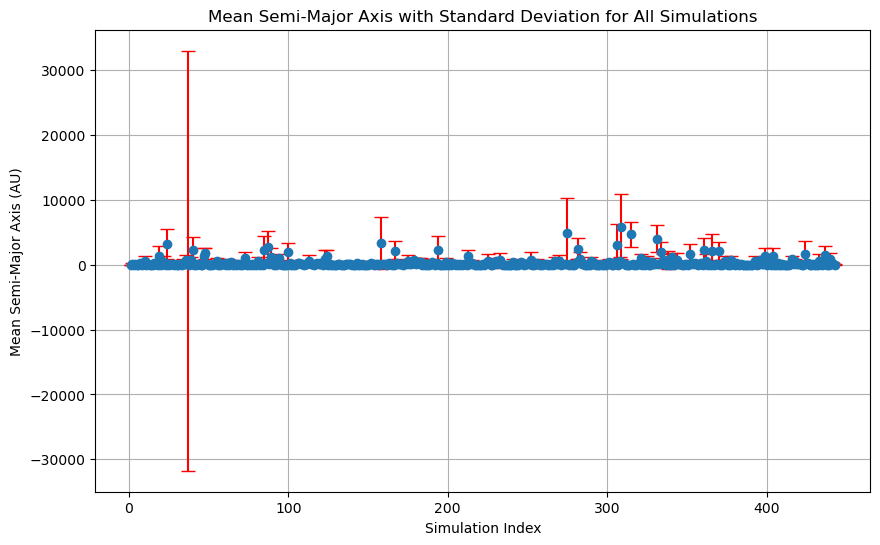

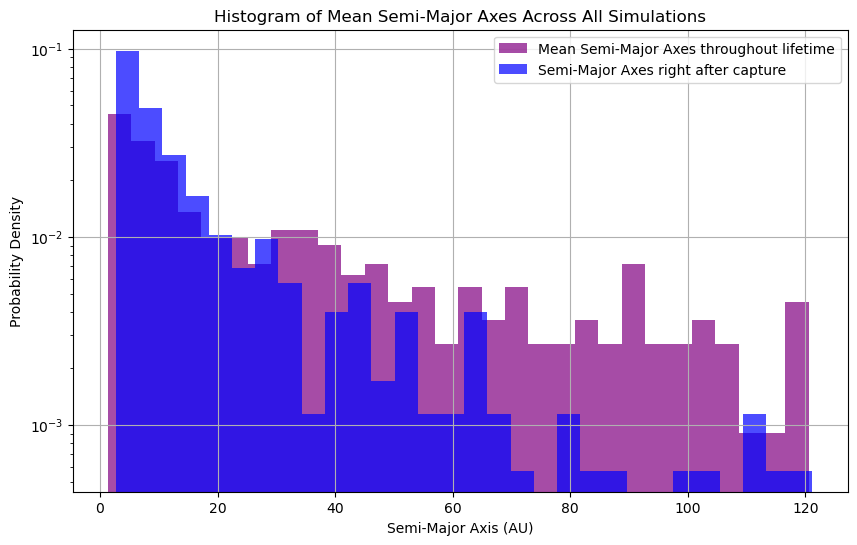

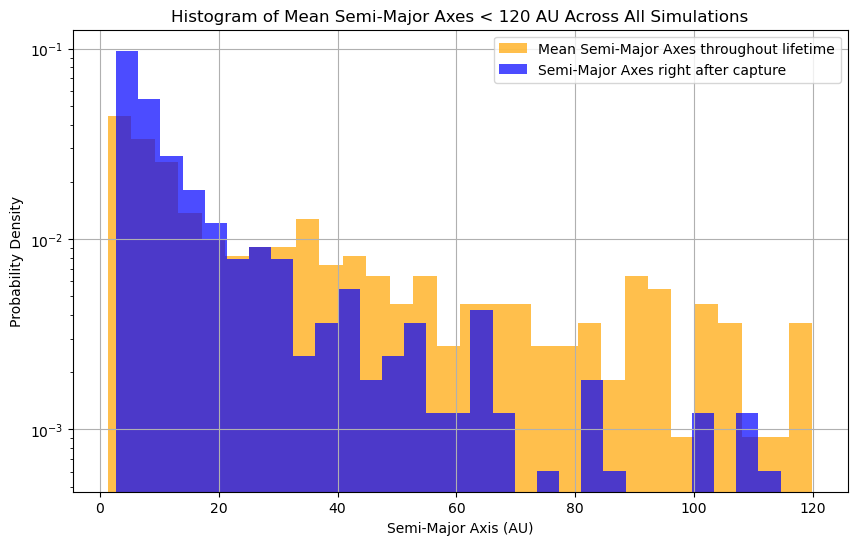

In [ ]:
print(len(all_semi_major_axes))
all_mean_a = []
all_std_a = []
for sma in all_semi_major_axes:
    a_values = sma[1]
    mean_a = np.mean(a_values)
    std_a = np.std(a_values)
    all_mean_a.append((sma[0], mean_a))
    all_std_a.append((sma[0], std_a))

print("Mean semi-major axes for all simulations:", all_mean_a)
print("Standard deviation of semi-major axes for all simulations:", all_std_a)

ax, fig = plt.subplots(figsize=(10, 6))
mean_a_values = [mean_a[1] for mean_a in all_mean_a]
std_a_values = [std_a[1] for std_a in all_std_a]
sim_indices = [mean_a[0] for mean_a in all_mean_a]
fig.errorbar(sim_indices, mean_a_values, yerr=std_a_values, fmt='o', ecolor='red', capsize=5)
fig.set_xlabel('Simulation Index')
fig.set_ylabel('Mean Semi-Major Axis (AU)')
fig.set_title('Mean Semi-Major Axis with Standard Deviation for All Simulations')
plt.grid()
plt.show()

# Now a histogram of mean semi-major axes
plt.figure(figsize=(10, 6))
max = np.max(a_au)
mean_a_vals = [mean_a[1] for mean_a in all_mean_a if mean_a[1] < max]
plt.hist(mean_a_vals, bins=30, density=True, color='purple', alpha=0.7)
plt.hist(a_au, bins=30, density=True, color='blue', alpha=0.7)
plt.legend(['Mean Semi-Major Axes throughout lifetime', 'Semi-Major Axes right after capture'])
plt.yscale('log')
plt.xlabel('Semi-Major Axis (AU)')
plt.ylabel('Probability Density')
plt.title('Histogram of Mean Semi-Major Axes Across All Simulations')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
mean_a_vals_less_120au = [a for a in mean_a_vals if a < 120.0]
plt.hist(mean_a_vals_less_120au, density=True, bins=30, color='orange', alpha=0.7)
plt.hist(a_less_120au, density=True, bins=30, color='blue', alpha=0.7)
plt.legend(['Mean Semi-Major Axes throughout lifetime', 'Semi-Major Axes right after capture'])
plt.yscale('log')
plt.xlabel('Semi-Major Axis (AU)')
plt.ylabel('Probability Density')
plt.title('Histogram of Mean Semi-Major Axes < 120 AU Across All Simulations')
plt.grid()
plt.show()


v_max: 25.414900505088962 km/s
1.6723797928325686e-17


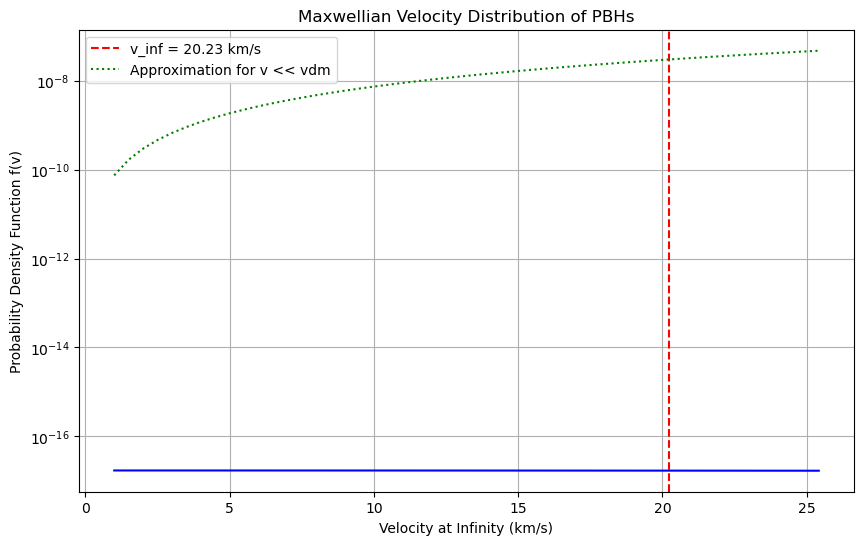

In [ ]:
vdm = 220 * 1e3  # m/s
v1_max = vesc + v_Jup
v_max = np.sqrt(v1_max**2 - 2*muA/r_SJ - 2*muB/rclose)
print(f'v_max: {v_max/1e3} km/s')
vinfinity = np.linspace(1e3, (v_max), 50)  # m/s
# vinfinity_tail = np.linspace(1e3, (vdm/1e2), 1000)  # m/s
f = (1/(((np.pi)**(3/2))*(vdm**3))) * (np.exp(-vinfinity**2/(vdm**2)))
f_20 = (1/(((np.pi)**(3/2))*(vdm**3))) * (np.exp(- (v_inf)**2/(vdm**2)))
f_approx = (np.sqrt(2/np.pi)) * (vinfinity**2 / (vdm**3)) * np.exp(- (vinfinity)**2/(2*vdm**2))
print(f_20)
plt.figure(figsize=(10, 6))
plt.plot(vinfinity/1e3, f, color='blue')
plt.axvline(x=v_inf/1e3, color='red', linestyle='--', label='v_inf = 20.23 km/s')
plt.plot(vinfinity/1e3, f_approx, color='green', linestyle=':', label='Approximation for v << vdm')
plt.legend()
plt.yscale('log')
plt.xlabel('Velocity at Infinity (km/s)')
plt.ylabel('Probability Density Function f(v)')
plt.title('Maxwellian Velocity Distribution of PBHs')
plt.grid()
plt.show()

mean lifetime (Myr): 0.8186663926663174, std: 1.5688415284483126
ejection rate (1/Myr): 1.2214987801601294
443


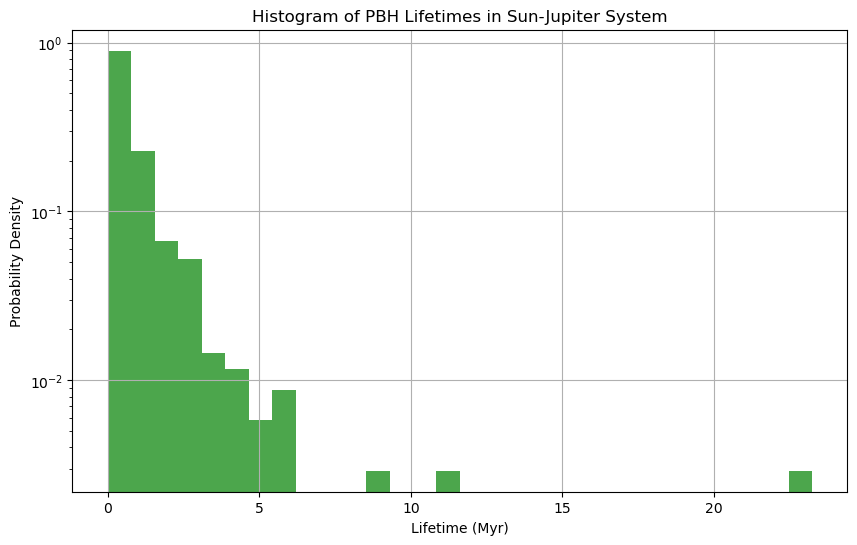

In [ ]:
# plot lifetime distribution
lifetimes = [lifetime[1]/1e6 for lifetime in all_lifetimes if lifetime[1] is not None]
ejection_rate = len([l for l in lifetimes if l < 1e4]) / np.sum(lifetimes)
mean_lifetime_all = np.mean(lifetimes)
std_lifetime_all = np.std(lifetimes)
print(f'mean lifetime (Myr): {mean_lifetime_all}, std: {std_lifetime_all}')
print(f'ejection rate (1/Myr): {ejection_rate}')
print(len(lifetimes))
plt.figure(figsize=(10, 6))
plt.hist(lifetimes, bins=30, density=True, color='green', alpha=0.7)
plt.yscale('log')
plt.xlabel('Lifetime (Myr)')
plt.ylabel('Probability Density')
plt.title('Histogram of PBH Lifetimes in Sun-Jupiter System')
plt.grid()
plt.show()

In [ ]:
v1Mag_au = v1Mag * (u.m / u.s).to(u.au/u.s) # convert to m/s
N_eq_v20 = f_20 * sigma_MC * (v1Mag_au) / ejection_rate  # captures per second at v_inf = 20 km/s
print(f'Number of captures per second at v_inf = 20 km/s: {N_eq_v20}')
print(vesc/1e3)
print(v1Mag/1e3)
print(vesc/v_inf)
print(vesc/v1Mag)

Number of captures per second at v_inf = 20 km/s: 4.4312045344484086e-07
18.47168172957672
27.524219970995567
0.9130836247937082
0.6711064563879297


In [ ]:
v_grid = np.linspace(0, v_max, N)
g_vals = g(v_grid)   # your integrand
I_N = np.trapz(g_vals, v_grid)
print("Integral I_N:", I_N)

NameError: name 'g' is not defined